# Temporal-Difference Methods: SARSA

In this notebook you will write your own implementation of SARSA method.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import random
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

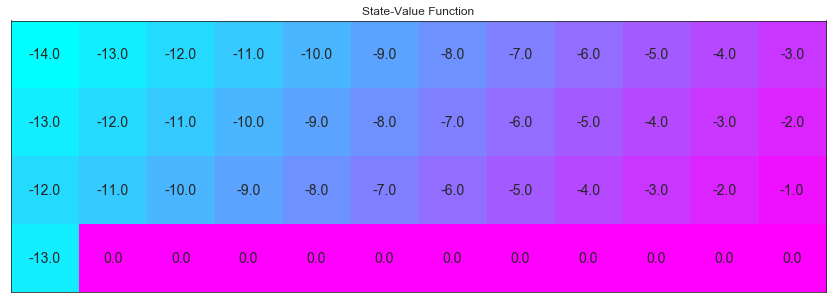

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [5]:
def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Parameters
    ==========
        Q (dictionary): action value function, Q[s][a] is the estimated 
                        action value corresponding to state s and action a.
        state (int): current state of the CliffWalkingEnv
        nA (int): number of possible actions in the environment
        eps(float): epsilon
    """
    
    if random.random() > eps:
        return np.argmax(Q[state])
    else:
        return random.choice(np.arange(nA))

In [6]:
def update_Q_sarsa(alpha,gamma,Q,state,action,reward,next_state=None,next_action=None):
    """Returns updated Q-value for the most recent experience.
    
    Parameters
    ==========
    alpha, gamma (float): parameters from the formula defining SARSA method
    Q (dictionary): action value function, Q[s][a] is the estimated 
                    action value corresponding to state s and action a.
    state (int): current state S_t
    action (int): current action A_t
    reward (int): reward R_{t+1}
    next_state (int) : next state S_{t+1}
    next_action (int): next_action A_{t+1}
    
    """
    
    # Estimate in Q-table (for current state, action pair) Q(S_t,A_t)
    current = Q[state][action] 
    # Get value of state, action pair at next time step Q(S_{t+1},A_{t+1})
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0
    # Construct TD target R_{t+1} + gamma * Q(S_{t+1},A_{t+1})
    target = reward + (gamma * Qsa_next)
    # Get updated value Q(S_t,A_t) + alpha * (R_{t+1} + gamma * Q(S_{t+1},A_{t+1}) - Q(S_t,A_t))
    new_value = current + alpha * (target - current)
    
    return new_value
    

In [7]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    # initialize performance monitor
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## ---> COMPLETE THE FUNCTION <---
        # Set epsilon
        eps = 1.0 / i_episode
        # Initialize score
        score = 0
        # Observe S_0: the initial state is #36
        state = env.reset()
        # Choose action A_0 using policy derived from Q (e.g., eps-greedy)
        action = epsilon_greedy(Q, state, nA, eps)

        while True:
            next_state, reward, done, info = env.step(action) # take action A, observe R', S'
            score += reward                                   # add reward to agent's score
            if not done:
                # Choose action A_{t+1} using policy derived from Q (e.g., eps-greedy)
                next_action = epsilon_greedy(Q, next_state, nA, eps) 
                # Update Q
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, state, action, 
                                                  reward, next_state, next_action)
                # Update state and action
                state = next_state     # S_t <- S_{t+1}
                action = next_action   # A_t <- A_{t+1}
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, 
                                                  state, action, reward)
                break 
    
    return Q

In [8]:
# Little test 
# UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3
Q_sarsa = sarsa(env, 500, .01)
state_number = 33 # pick a value between 0 and 36
print("\n best action:",np.argmax(Q_sarsa[state_number]),"\n action values:", Q_sarsa[state_number])

policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
print("\n",policy_sarsa)

Episode 500/500
 best action: 0 
 action values: [-2.55483932 -2.55805957 -7.54982841 -2.56856832]

 [[ 3  1  1  1  1  2  3  1  0  2  1  0]
 [ 1  0  2  0  2  2  1  3  0  0  0  2]
 [ 3  0  3  3  3  1  0  3  3  0  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  3  1  2  1  1  1  1  1  1  2]
 [ 0  2  2  3  1  2  3  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


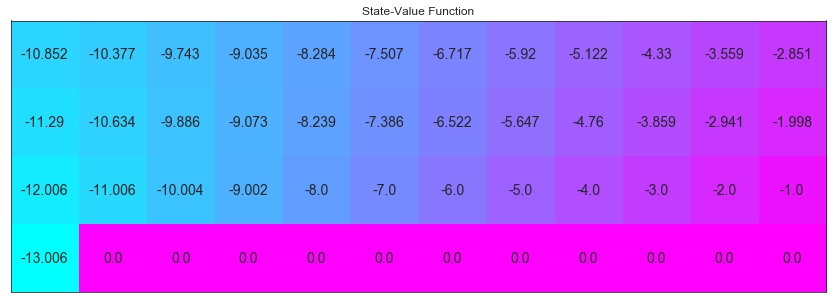

In [11]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)